In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 1. Cargar los datos
datos = pd.read_csv('water_potability.csv').dropna()
print("Forma por defecto del dataset '.csv': \n", list(datos.keys()))

# 2. Preprocesar los datos si es necesario
X = datos.drop('Potability', axis=1)
y = datos['Potability']

# 3. Dividir los datos en conjuntos de entrenamiento y prueba, otra vez, ya que quiero que todos sean clase pd.DataFrame
features = list(datos.keys())
features.remove('Potability')
X_train3, X_temp3, y_train3, y_temp3 = train_test_split(datos[features], datos['Potability'], test_size=0.2)
X_val3, X_test3, y_val3, y_test3 = train_test_split(X_temp3, y_temp3, test_size=0.5)

Forma por defecto del dataset '.csv': 
 ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity', 'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'Potability']


In [3]:
"""
Aquí secuestramos la función para normalizar que habíamos hecho en la tarea 1. Y luego la usamos para normalizar los datos de la tarea 3, en el punto 3.
Los datos de validación y test se normalizaron con la media y la desviación de los datos de entrenamiento
"""
parametros_train = dict(map(lambda x: (x, {'media': np.mean(X_train3[x]), 'desviacion': np.std(X_train3[x])}), X_train3.keys()))
def normalizar(dataSet, features, parametros = []):
    """
    Esta función resta la media y luego divide entre la desviación estandar de cada dato en cada columna. Si se le especifica la media y la desviación en los parámetros 
    Usa esa media y desviación dada, de lo contrario, calcula la media y la desviación de cada columna especificada en "features"
    @input: dataSet <pd.DataFrame>: Tabla de datos a la que se le va a dar normalización a la columans dadas
    @input: features <list>: lista de "features" o columnas que se van a normalizar
    @input: (opcional) parametros <dict>: En caso de que se quiera normalizar con una media y una desviación dada se especifican en un diccionario así: {'mileage':{'media': 2.9, 'desviacion': 7}}
    """
    if len(parametros) == 0:
        for feature in features:
            media = np.mean(dataSet[feature])
            desviacion = np.std(dataSet[feature])
            if desviacion != 0:
                dataSet[feature] = (dataSet[feature] - media)/desviacion
            #fin if 
        #fin for
    #fin if 
    else:
        for feature in features:
            media = parametros[feature]['media']
            desviacion = parametros[feature]['desviacion']
            if desviacion != 0:
                dataSet[feature] = (dataSet[feature] - media)/desviacion
            #fin if 
        #fin for
#fin función
normalizar(X_train3, features)
normalizar(X_val3, features, parametros_train)
normalizar(X_test3, features, parametros_train)

In [4]:
a = list(map(lambda x: x, X_train3.to_dict(orient = 'index')))
print(X_train3.to_dict(orient = 'index').values())

dict_values([{'ph': 0.62436387369812, 'Hardness': 0.07599693888377805, 'Solids': -0.4259949295137935, 'Chloramines': -0.1388629195951337, 'Sulfate': 1.5607889381812925, 'Conductivity': -0.630722523818037, 'Organic_carbon': -1.0299328224626965, 'Trihalomethanes': 1.3136556775628556, 'Turbidity': -1.1712154357986775}, {'ph': 2.342434298298768, 'Hardness': 0.06781958694271728, 'Solids': 0.867373560139343, 'Chloramines': -0.8548186261103216, 'Sulfate': -0.6764253826566777, 'Conductivity': -0.5481702085951962, 'Organic_carbon': 0.16765236268260741, 'Trihalomethanes': -1.1458583881174917, 'Turbidity': 0.49369597230273526}, {'ph': -1.07062042298135, 'Hardness': -0.7754889879310292, 'Solids': 0.5921550461181633, 'Chloramines': 0.6049419780516915, 'Sulfate': 1.060712137046003, 'Conductivity': -0.31453012024373606, 'Organic_carbon': -0.0794406940326284, 'Trihalomethanes': 0.9623659406195708, 'Turbidity': -0.7868320081516796}, {'ph': -0.4528121706036312, 'Hardness': 0.9376953246577445, 'Solids': 

En la siguiente celda se escribió la implementación de AdaBoost usando como clasificador débil decision stump de sci-kit learn. 

In [5]:
def AdaBoostear(datos, etiquetas, N_clasificadores):
    """
    Esta función entrena un decision stump N_clasificadores veces siguiendo el algoritmo de AdaBoost. Para ello inicia un vector D de pesos iguala 1/N_datos. Luego entrena un decision stump 
    con los datos ponderados de acuerdo a D y predice los datos de acuerdo a ese modelo, lo cual genera un vector de valores entre 0 y 1. Esta vector y el vector de etiquetas se trnasforman 
    en vectores cuyos valores van entre -1 y 1 para que puedas ser multiplicados. COn estos vectores entre -1 y 1 se calculan los valores de los errores, alpha y los D's en la siguiente
    iteración. AL repetir este proceso N_clasificadores veces se obtienen N_clasificadores alphas y N_clasificadores modelos. Tanto los valores de alpha como los errores y lso modelos son 
    almacenados en el diccionario que esta función devuelve
    @input datos <pd.DataFrame>: Datos que se usarán para el entrenamiento del modelo. 
    @input etiquetas <np.array>: Etiquetas de cada uno de los datos, las cuales son representadas con el número 0 o el número 1
    @input N_clasificadores <int>: Número de iteraciones o de clasificadores del cual se compone el modelo final. En el enunciado este número es 600
    @output lista_modelos <dict>: Diccionario que tiene toda la información necesaaria que se obtiene en cada iteración como los alphas y lso modelos
    """
    D = (1/len(datos.index))*np.ones(len(datos.index)) 
    lista_modelos = []
    for k in range(N_clasificadores):
        modelo = DecisionTreeClassifier(max_depth=1)
        modelo.fit(datos, etiquetas, sample_weight=D)
        #estimaciones_modelo es un vector cuyos valores van entre 0 y 1, tal como las etiquetas de y, endonde 0 indica agua no potable y 1 indica agua potable
        estimaciones_modelo = modelo.predict(datos)
        #este es un vector que guarda los valores de (y_i)*hk(x_i). Primero transforma los vectores de "y" y de las estimaciones a valores entre -1 y 1, para luego multiplicar cada uno de los valores
        #generando otro vector entr -1 y 1. Luego transforma es evector en uno que está entre 0 y 1
        aciertos = 0.5*((2*estimaciones_modelo - 1)*(2*etiquetas - 1) + 1)
        descaches = 1 - aciertos
        #Este producto punto en error_k garantiza que solo los D's correspondientes a fallos sean sumados
        error_k = D.dot(descaches)
        alpha_k = 0.5*np.log((1-error_k)/error_k)
        vector_exponenciales = np.exp(-alpha_k*(2*aciertos - 1))
        z_k = D.dot(vector_exponenciales)
        D_nuevo = (1/z_k)*(D*vector_exponenciales)
        lista_modelos.append({'alpha': alpha_k, 'arbol': modelo, 'D': D, 'Error': error_k})
        D = D_nuevo[:]
    #fin for
    return lista_modelos
#fin función

In [6]:
modelo_adaboost_train = AdaBoostear(X_train3, y_train3, 600)
modelo_adaboost_validate = AdaBoostear(X_val3, y_val3, 600)

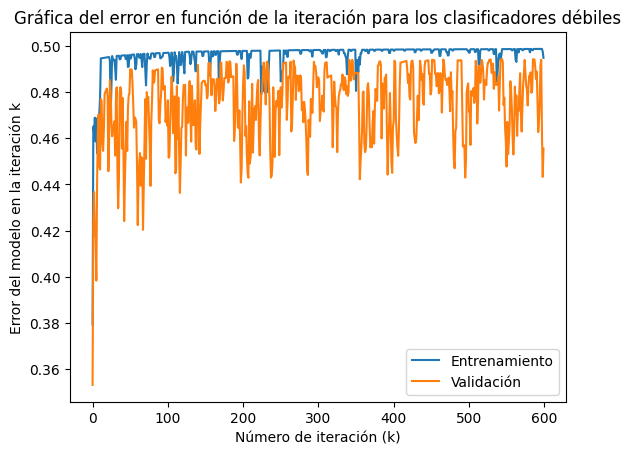

In [7]:
N_puntos = 600
iteracion = np.linspace(0,N_puntos - 1, N_puntos)
errores_train = list(map(lambda x: x['Error'], modelo_adaboost_train))[:N_puntos]
errores_val = list(map(lambda x: x['Error'], modelo_adaboost_validate))[:N_puntos]
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.plot(iteracion, errores_train, label = 'Entrenamiento')
ax1.plot(iteracion, errores_val, label = 'Validación')
ax1.set_xlabel('Número de iteración (k)')
ax1.set_ylabel('Error del modelo en la iteración k')
ax1.set_title('Gráfica del error en función de la iteración para los clasificadores débiles')
ax1.legend(loc = 'lower right')

In [8]:
def Evaluar_Adaboost(datos, lista_dic_adaboost):
    """
    Esta función retorna la suma f de todos los modelos en Adaboost multiplicados por su respectivo parámetro alpha
    @intput datos <pd.DataFrame>: Datos a los cuales se les va a predecir la etiqueta
    @input lista_dic_adaboost <list>: Lista de diccionarios que tiene toda la información de los valores (por ejemplo alpha) y modelos obtenidos con AdaBoost
    @output <np.array>: Etiquetas predichas por el nuevo modelo compuesto
    """
    suma = 0
    for i in range(len(lista_dic_adaboost)):
        termino = lista_dic_adaboost[i]['alpha']*(2*lista_dic_adaboost[i]['arbol'].predict(datos) - 1)
        suma += termino
    #fin for
    return 0.5*(np.sign(suma) + 1)
#fin funcion

def hallar_aciertos(y, predicción):
    """
    Esta función halla el porcentaje de aciertos de un modelo comparando las etiquetas (y) con el vector de predicciones. 
    @input y <np.array>: vector que contiene las etiquetas reales
    @input predicción <np.array>: vector que contiene las etiquetas predichas por el modelo
    @output Aciertos <float>: porcentaje de aciertos del modelo
    """
    multi = 0.5*((2*y - 1)*(2*predicción -1) + 1) 
    Aciertos = (1/(len(y)))*sum(multi)
    return Aciertos
#fin funcion

In [9]:
evaluacion_train = Evaluar_Adaboost(X_train3, modelo_adaboost_train)
evaluacion_test = Evaluar_Adaboost(X_test3, modelo_adaboost_train)

In [10]:
aciertos_test = hallar_aciertos(y_test3, evaluacion_test)
aciertos_train = hallar_aciertos(y_train3, evaluacion_train)

In [11]:
print("-@AdaBoost-")
dic_mejor_clasificador = min(modelo_adaboost_train, key = lambda x: x['Error'])
exito_mejor_clasificador_train = 1 - dic_mejor_clasificador['Error']
evaluacion_mejor_clasificador_test = dic_mejor_clasificador['arbol'].predict(X_test3)
aciertos_mejor_clasificador_test = hallar_aciertos(y_test3, evaluacion_mejor_clasificador_test)
print("Porcentaje de éxito del mejor clasificador debil en los datos de Entrenamiento: ", exito_mejor_clasificador_train)
print("Porcentaje de éxito del modelo de AdaBoost en los datos de Entrenamiento: ", aciertos_train)
print("Porcentaje de éxito del mejor clasificador debil en los datos de Test: ", aciertos_mejor_clasificador_test)
print("Porcentaje de éxito del modelo de AdaBoost en los datos de Test: ", aciertos_test)

-@AdaBoost-
Porcentaje de éxito del mejor clasificador debil en los datos de Entrenamiento:  0.6206467661691539
Porcentaje de éxito del modelo de AdaBoost en los datos de Entrenamiento:  0.6498756218905473
Porcentaje de éxito del mejor clasificador debil en los datos de Test:  0.5792079207920792
Porcentaje de éxito del modelo de AdaBoost en los datos de Test:  0.5841584158415841
